# CUNY MSDS DATA620 - Web Analytics

# Project 2 | Presumed Suspect

## Prof: Alain Ledon
## Team1 : Tage Singh, Deepak Sharma, Ramnivas Singh

## Objective
Identify a large 2-mode network dataset—you can start with a dataset in a repository. Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?


## Introduction

This a bipartite network of associations among suspects, victims, and/or witnesses involved in crimes in St. Louis in the 1990s. Data are derived from police records, via snowball sampling from five initial homicides. Left nodes are people, right nodes are crime events, and edges connect people to particular crimes events they were associated with. Metadata includes names, genders, and roles (suspects, victims, and/or witnesses)..

We used the island method to identify connected subgroups in the data. Findings identified a small network involving Luella Katz, who was active as a suspect, victim or witness in 18 crimes. Katz also is connected to other highly active suspects. We identified Katz by using the island method and reducing the overall network from 829 unique persons to 28 who were connected in 12 groups by association in different crimes either as suspects, victims or witnesses. 

We also fond Crime 110 is on top for high betweeeness centrality: The crime involved 15 witnesses, 2 suspects and one victim.

Data source : http://moreno.ss.uci.edu/data.html#crime \
Data format : csv \
Node meaning : Person, crime \
Edge meaning : Involvment \
Network format : Bipartite 

## Analysis Questions
individual(s) that have the most shared connections with other individuals\
Crime(s) that have the most shared connections with other crimes\
People that can help with investigating a crime's person
Persons are implicated in the most number of crimes\



In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
import networkx.algorithms.bipartite as bp
from prettytable import PrettyTable

## 1. Data Import

There are four main files that we worked with, the data on crimes, the data on the relationships of the people to the crimes, the names of the individuals, and the gender of the individuals. The following code imports the various files and uses the dataframe features of *pandas* to create our crime data set that is needed to build our graph.

### 1.1 Nodes, edges
To setup data sctructure we have import the data file. 

In [2]:
# Import person data
names = pd.read_csv('https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/project2/ent.moreno_crime_crime.person.name', sep='\t', header=None)
names.columns = ['name']
# Import gender data
names['Gender'] = pd.read_csv('https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/project2/ent.moreno_crime_crime.person.sex', header=None)
names.head()

,name,Gender
0,AbelDennis,1
1,AbramsChad,1
2,AbramsDavid,1
3,AbramsDon,1
4,AbramsRichard,1


In [3]:
# Import crime data
crime = pd.read_csv("https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/project2/out.moreno_crime_crime", delim_whitespace=True, header=None, skiprows=[0,1], names=['Person', 'Crime'])
# Import relationship data
crime['Relationship'] = pd.read_csv("https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/project2/rel.moreno_crime_crime.person.role", header=None)
crime.head()

## segregating attributes here to get a relationship count and a total crime count 
crime['crime_count'] = crime.groupby(['Person'])['Crime'].transform('count')


### 1.2 Total number of Persons

In [4]:
# Total number of people
len(crime.Person.unique())

829

### 1.3 Total number of Crimes

In [5]:
# Total number of crimes
len(crime.Crime.unique())

551

### 1.4 Table of Relationships

In [6]:
# checking relationships 
rels = crime.groupby('Relationship').count().iloc[:,0]
rels

Relationship
Suspect           682
Victim            558
Victim Suspect     41
Witness           195
Name: Person, dtype: int64

### 1.5 Add Person, Crime ID, Relationship, Count of Relationship, Count of Crime, Gender

In [7]:
names.loc[names.Gender == 1, 'Gender'] = 'Male'
names.loc[names.Gender == 0, 'Gender'] = 'Female'
names.head()

,name,Gender
0,AbelDennis,Male
1,AbramsChad,Male
2,AbramsDavid,Male
3,AbramsDon,Male
4,AbramsRichard,Male


In [8]:
def get_name(PersonId):    
    return names.loc[int(PersonId)].at['name']

for i in range(0,len(names)):
    crime.at[crime.Person == i+1, 'Gender'] = names.iloc[i][1]
    crime.at[crime.Person == i+1, 'Person'] = names.iloc[i][0]

### 1.6 Suspect, Victim, Witness Overlap

Identifying a true criminal network, then, will require filtering out suspects. Complicating the analysis is that many of the victims have also been suspsects in different crimes, and vice versa. Many victims are also listed as witnesses. Nearly a fourth of all suspects were also crime victims. 

As an example -  Luella Katz is involved with 18 crimes – 15 as a suspect, twice as a victim and once as a witness.

In [9]:
from tabulate import tabulate
## make sets of the suspect, victim and witness nodes, then compute overlap
suspects = set(crime[crime['Relationship'] == "Suspect"].iloc[:, 0].unique())
victims = set(crime[crime['Relationship'] == 'Victim'].iloc[:,0].unique())
witness = set(crime[crime['Relationship'] == "Witness"].iloc[:, 0].unique())

table = [['Suspect', 'Victim', 'Witness'], 
         [len(suspects), len(victims), len(witness)]]
print(tabulate(table))
print('')
table = [['Suspect and Victim', 'Suspect and Witness','Victim and Witness'], 
         [len(suspects.intersection(victims)), 
          len(suspects.intersection(witness)), 
          len(victims.intersection(witness))]]
print(tabulate(table))

-------  ------  -------
Suspect  Victim  Witness
412      369     189
-------  ------  -------

------------------  -------------------  ------------------
Suspect and Victim  Suspect and Witness  Victim and Witness
94                  41                   52
------------------  -------------------  ------------------


## 2. Bipartite Graph
Now that we have our dataframe of the crimes commited in the St. Louis data, we can start to build our crime graph.

### 2.1 Loading Nodes and Edges Separately

We start by adding in our person and crime nodes to our empty graph individually. Once we have these nodes in the graph, we then itterate over the data to add edges between all of the nodes.

In [10]:
## reloading data in bipartite fashion
G = nx.Graph()
# add person nodes
for i in range(len(crime)): 
    G.add_node(crime.iloc[i][0],
                Relation=crime.iloc[i][2],
                weight=crime.iloc[i][3],
                Gender=crime.iloc[i][4],
                bipartite=1)

In [11]:
# add crime nodes 
for i in range(len(crime)): 
    G.add_node(crime.iloc[i][1],
                bipartite=0)

In [12]:
# add edges
# There's an edge between two stations if there was a trip between them.
# Edges are weighted by the number of trips
for i in range(len(crime)):
    G.add_edge(crime.iloc[i][0], crime.iloc[i][1], weight=1)

In [13]:
# Checking the stucture of the graph
nx.is_connected(G), nx.is_bipartite(G)

(False, True)

In [14]:
# Generaing a list of top_nodes(people) and bottom_nodes(crime)
person_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==1)
crime_nodes = set(G) - person_nodes

### 2.2 Examining Nodes
Now that we have our graph constructed we can examine the two types of nodes. Notice that the type of crime isn't provided; there is simply a number value given to each crime event.

In [15]:
# a bit of info about the graph
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 1476
Average degree:   2.1391


## 3. Bipartite Projection – Person

### 3.1 Island Analysis – Persons

We used the island method after creating a weighted bipartite graph. Weights are the number of shared neighbors for an edge. First we isolate the biggest component of the bipartite graph, then we apply the island method and print the threshold level, the size of the graph, and the number of connected components.

In [16]:
## Implementing the Island Method to look for important subgroups. ##
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    island_graph = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            island_graph.add_edge(f,to)
    return island_graph

    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
def island_method(g, iterations=5, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

### 3.2 Island method results

A threshold value of 2 results in a network of 28 Persons and 12 connected components. Of particular interest are suspect nodes connected to Luella Katz, the most-connected suspect in the graph with a degree centrality of 51. Katz is also connected to two other high-degree suspects, Michael Thomas Smith (33 degrees) and Catherine Steiner (29). Both are in the top 10 list of suspects by degree centrality.

In [17]:
projected_graph_person = nx.bipartite.weighted_projected_graph(G, person_nodes)
connected_component_subgraphs = (projected_graph_person.subgraph(c) for c in nx.connected_components(projected_graph_person))
connected_component_person = max(connected_component_subgraphs, key=len)

In [18]:
islands = island_method(connected_component_person, iterations = 3)
print('Min weight ', '# of nodes (Persons) - ', '# of island subgraphs')
for island in islands:
    print('   %d               %2d                   %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_components(island[1])))))


Min weight  # of nodes (Persons) -  # of island subgraphs
   1               89                   27
   2               28                   12
   3               15                    7
   4                6                    3


### 3.3 Plot of network at weight

In [19]:
def plot_network(threshold):
    ## Plotting created by the island analysis
    pc = trim_edges(connected_component_person, threshold)
    from nxviz import CircosPlot
    nx.draw(pc,with_labels=True,alpha=.50, font_size=18)

We plot network with threshold as 1,2,3 and 4

In [20]:
#plot_network(1)

In [21]:
#plot_network(2)

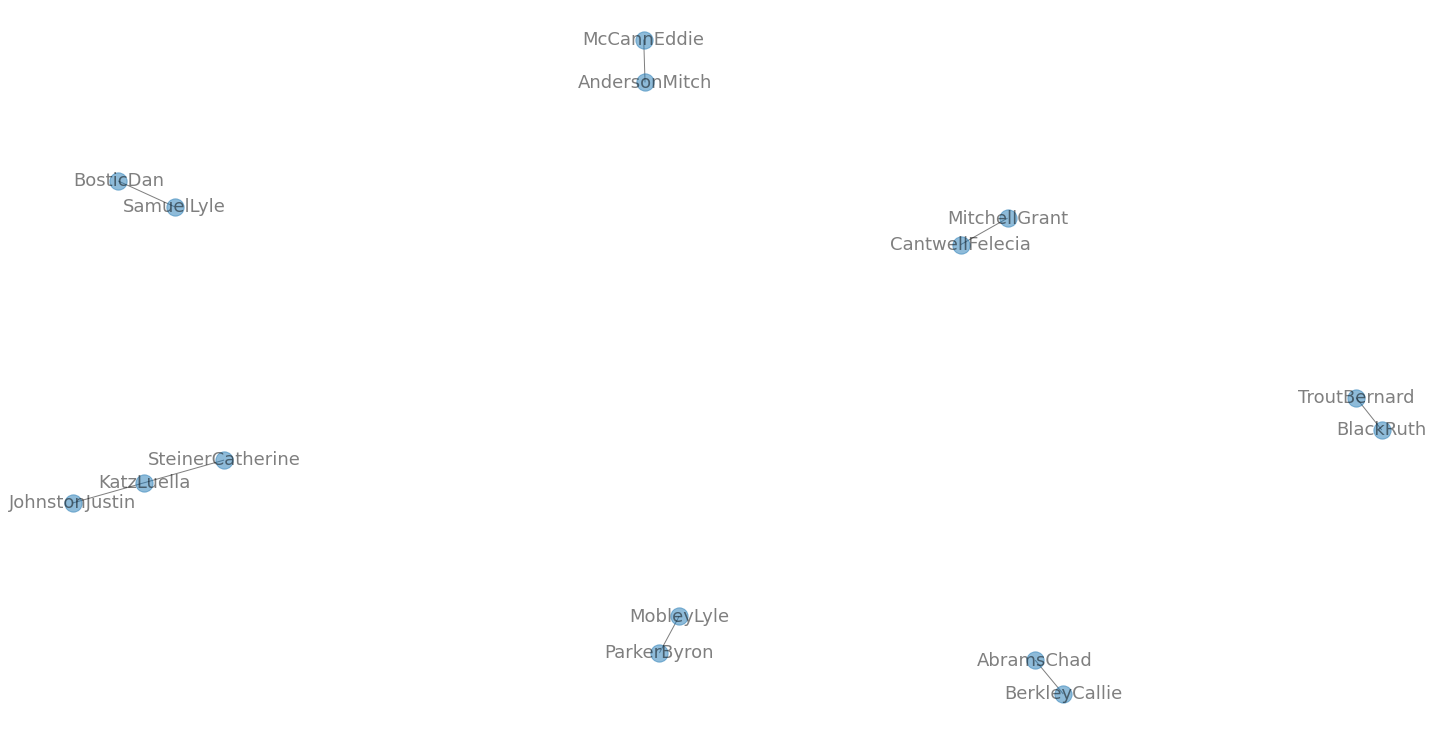

In [22]:
plot_network(3)

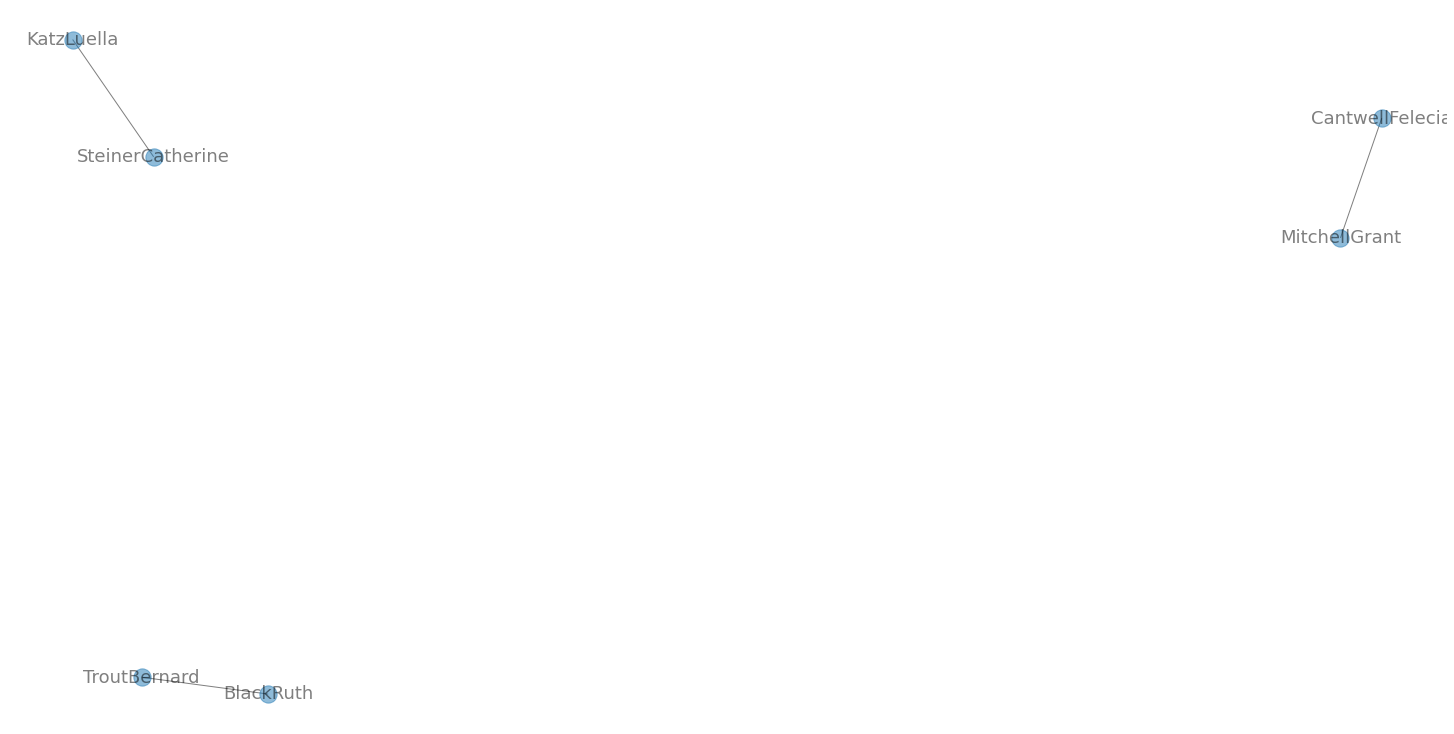

In [23]:
plot_network(4)

### 3.4 Luella Katz ego network

Katz is connected to 51 other persons. Those persons are listed as suspects in 40 crimes and victims in 22 crimes. 

In [24]:
luella_katz = crime[crime['Person']=='KatzLuella']
katz_connections = pd.DataFrame(connected_component_person.edges('KatzLuella'))
katz_con = set(katz_connections.iloc[:,1])
a = len(katz_con.intersection(victims))
b = len(katz_con.intersection(suspects))

print ('Victim connections:  ', a)
print ('Suspect connections: ', b)


Victim connections:   22
Suspect connections:  40


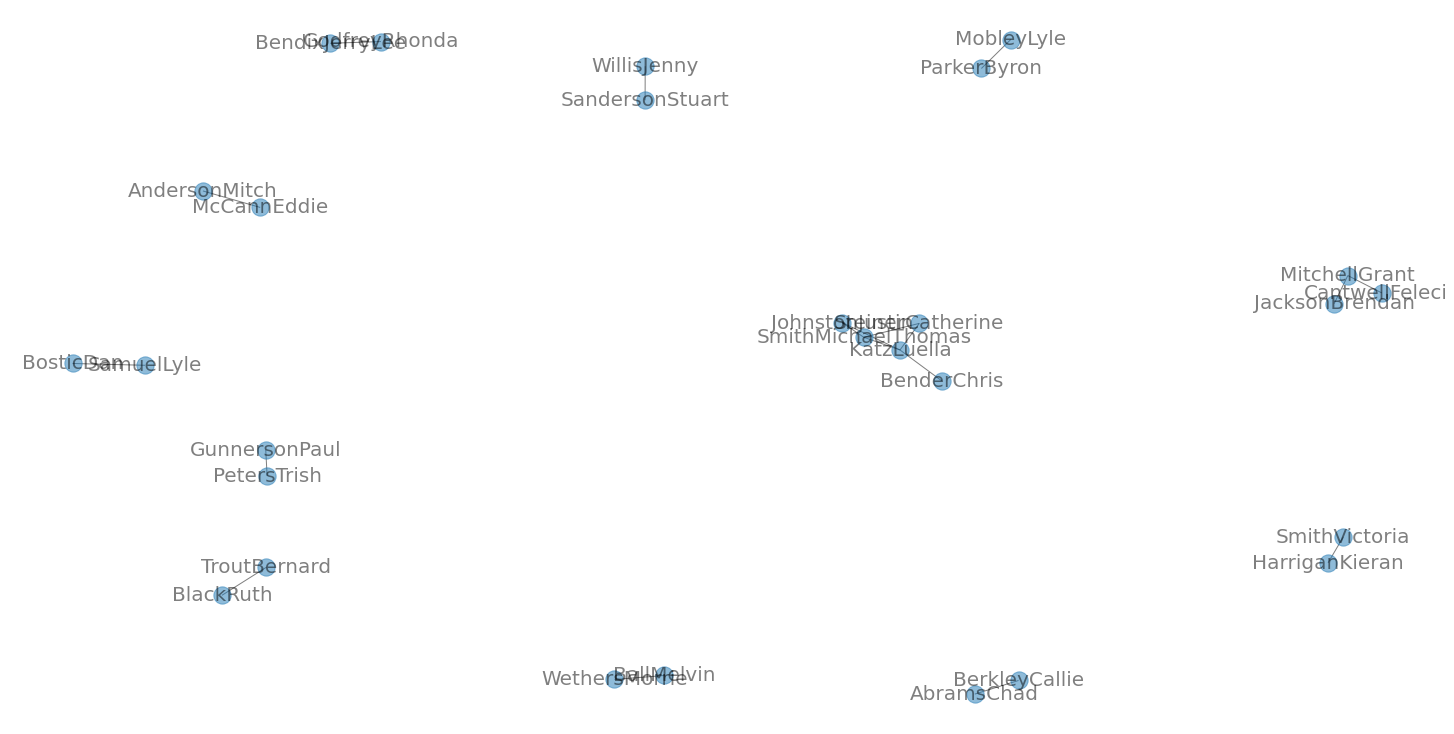

In [25]:
katz = nx.ego_graph(projected_graph_person, 'KatzLuella', radius=1, center=True, undirected=True, distance='weight')
dkatz = katz.degree()
pc = trim_edges(connected_component_person, 2)
nx.draw(pc, with_labels = True, alpha=.50, font_size=20)


## 4.  Bipartite Projection, Crimes

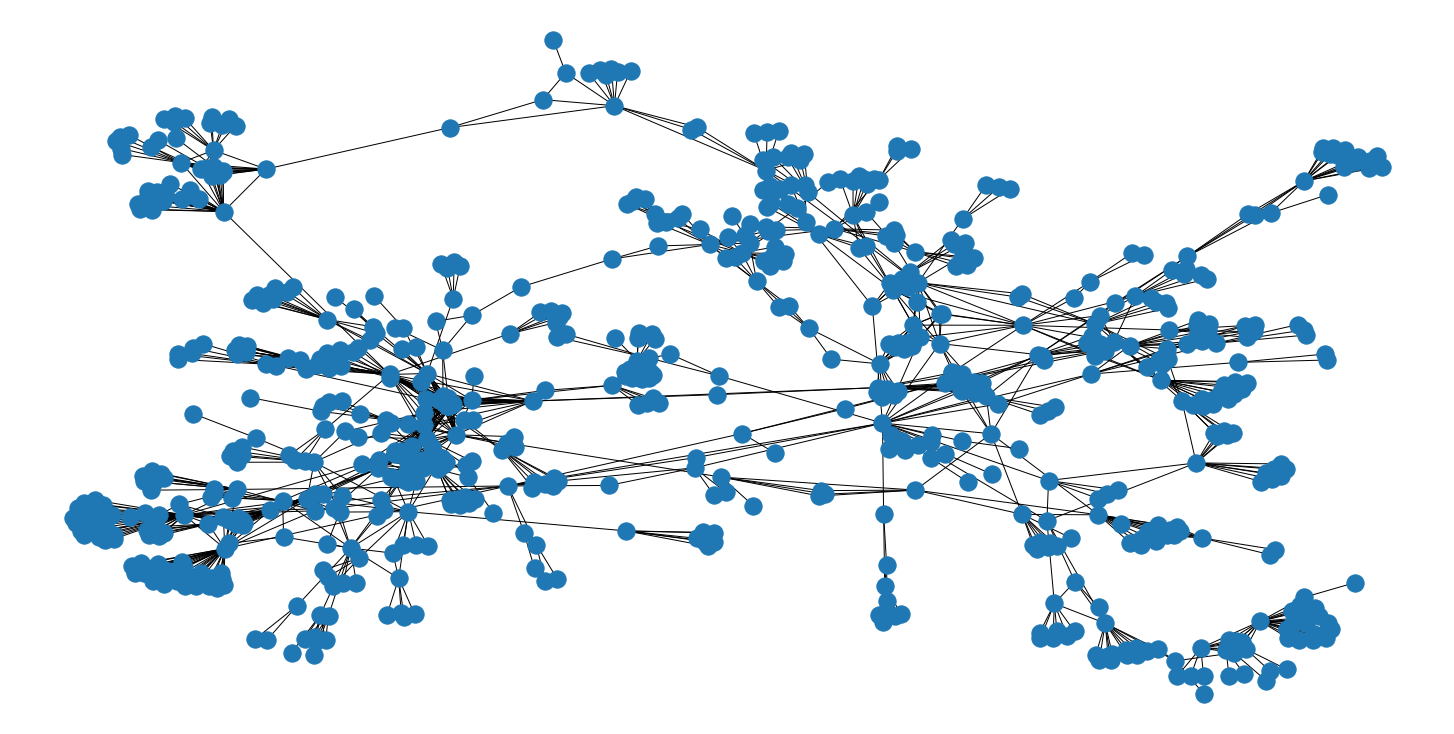

In [26]:
# project bipartite graph onto crime nodes now the degrees are their connections with other crimes 
# based on involvment by the same persons
connected_component = nx.bipartite.weighted_projected_graph(G, crime_nodes)
nx.draw(connected_component_person,with_labels=False)

### 4.1 Island Analysis – Crimes

The island analysis identifies a six-node network of crimes. Examination of the crimes shows they all involved Luella Katz and close associates who were suspects. Katz was a witness in crime 110 along with 14 other individuals.


In [27]:
## Running the Island Analysis on the graph. Will throw an error if the island_method is called with too many steps
islands = island_method(connected_component_person, iterations = 2)
print('Min weight ', '# of nodes (Persons) - ', '# of island subgraphs')
for island in islands:
    print('   %d               %2d                   %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_components(island[1])))))

Min weight  # of nodes (Persons) -  # of island subgraphs
   1               89                   27
   3               15                    7


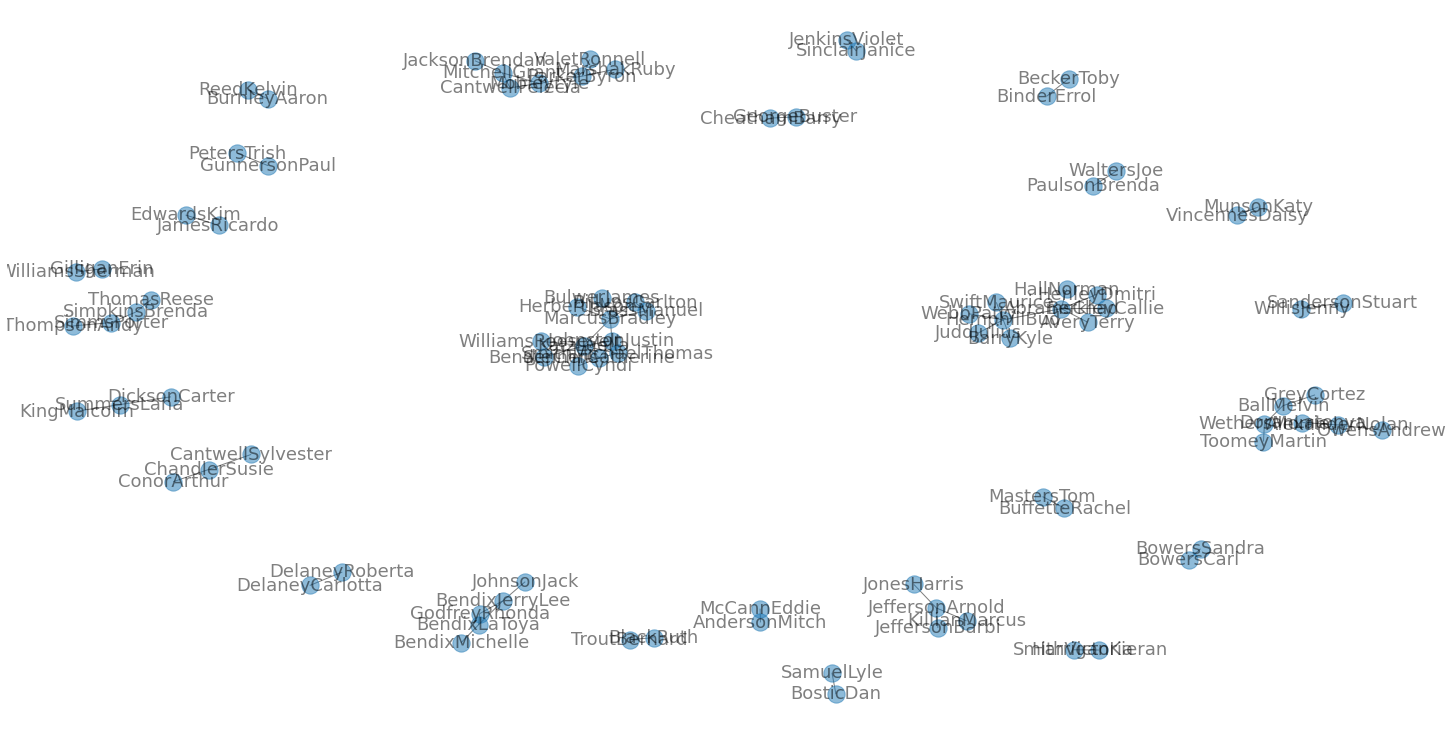

In [28]:
## Plotting the two graphs created by the island analysis
wc = trim_edges(connected_component_person, 1)
nx.draw(wc,with_labels=True, alpha=.50, font_size=18)

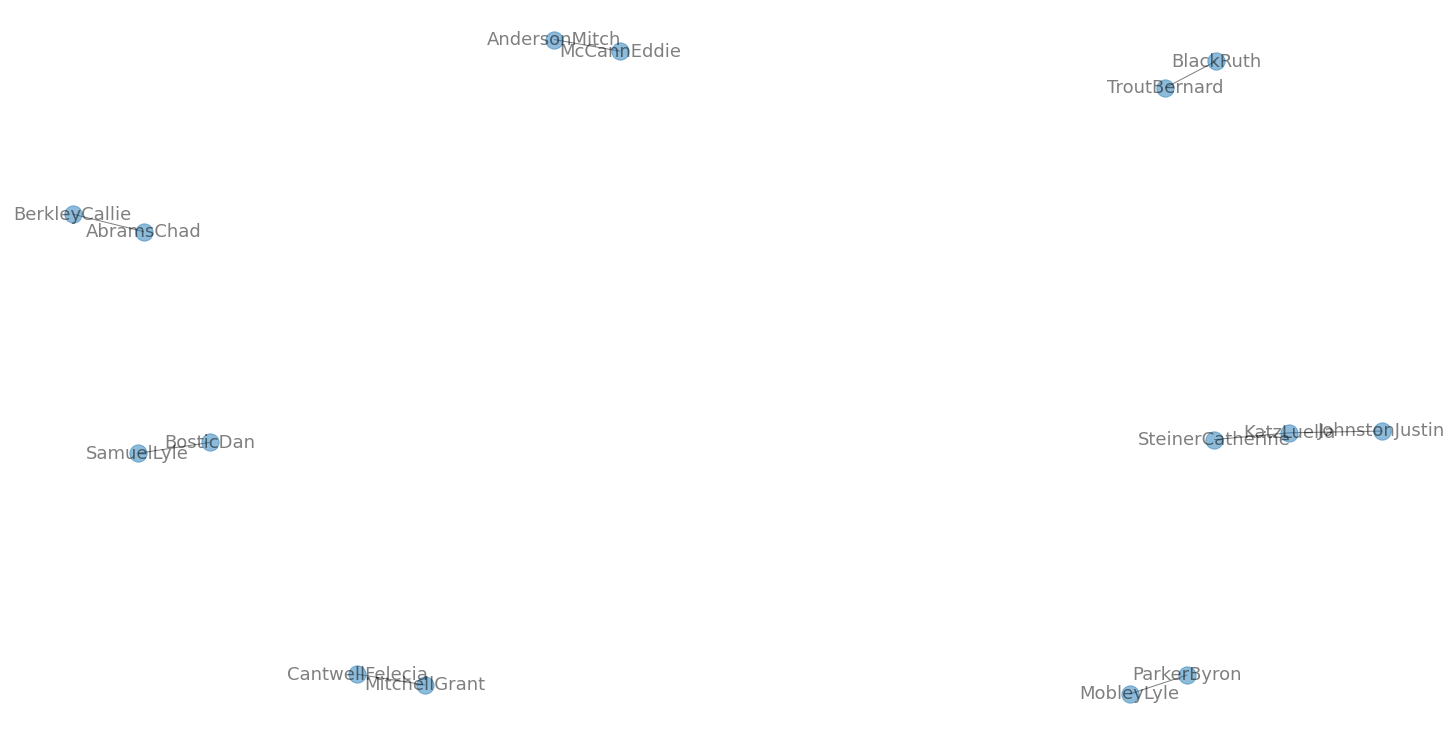

In [29]:
## Plotting the two graphs created by the island analysis
wc = trim_edges(connected_component_person, 3)
nx.draw(wc,with_labels=True, alpha=.50, font_size=18)

## 5. Centrality Measures
In the table below we take the bipartite weighted graph and examine centrality measures. 

In [30]:
def PrintTable(graph):
   degree = nx.degree(graph)
   degree_centrality = nx.degree_centrality(graph)
   betweenness_centrality = nx.betweenness_centrality(graph)
   closeness_centrality = nx.closeness_centrality(graph)
   eigenvector_centrality = nx.eigenvector_centrality_numpy(graph)
   table = [[name,degree[name], round(degree_centrality[name],3), round(betweenness_centrality[name],3),
             round(closeness_centrality[name],3), round(eigenvector_centrality[name],3)] for name in graph.nodes()]
   table = sorted(table,key = lambda x: -x[2])[:10]
   printTable = PrettyTable(['Subject','Degree','Degree Centrality','Betweenness','Closeness','Eigenvector'])
   for i in range(0, len(table)):
       printTable.add_row(table[i])
   return printTable

In [31]:
#print(PrintTable(G))

#### Table 1. Centrality measures compared

Per our visual analysis, Luella Katz's heavy involvement is confirmed; she ranks among the top 10 three centrality categories. Katz, Cathering Steiner and Michael Smith all are among the highest in eigenvector centrality – in other words, they are connected to other highly connected suspects and victims. Jenny Willis ranks high in betweenness and degree centrality.

In [32]:
print(PrintTable(connected_component_person))

+--------------------+--------+-------------------+-------------+-----------+-------------+
|      Subject       | Degree | Degree Centrality | Betweenness | Closeness | Eigenvector |
+--------------------+--------+-------------------+-------------+-----------+-------------+
|     KatzLuella     |   51   |       0.068       |     0.15    |    0.21   |    0.308    |
|     AbramsChad     |   48   |       0.064       |    0.226    |   0.217   |    0.013    |
|    HemphillBud     |   44   |       0.058       |    0.143    |   0.215   |    0.008    |
|   BendixJerryLee   |   33   |       0.044       |     0.19    |   0.197   |    0.215    |
| SmithMichaelThomas |   33   |       0.044       |    0.049    |   0.205   |    0.261    |
|   MarcusBradley    |   30   |        0.04       |    0.025    |   0.192   |     0.12    |
|  SteinerCatherine  |   29   |       0.039       |    0.186    |   0.216   |    0.225    |
|   AlexanderNolan   |   28   |       0.037       |    0.113    |   0.174   |   

In [33]:
projected_graph_crime = nx.bipartite.weighted_projected_graph(G, crime_nodes)
connected_component_subgraphs = (projected_graph_crime.subgraph(c) for c in nx.connected_components(projected_graph_crime))
connected_component_crime = max(connected_component_subgraphs, key=len)

Crime 110 is of note for high betweeeness centrality: The crime involved 15 witnesses, 2 suspects and one victim.

In [34]:
print(PrintTable(connected_component_crime))

+---------+--------+-------------------+-------------+-----------+-------------+
| Subject | Degree | Degree Centrality | Betweenness | Closeness | Eigenvector |
+---------+--------+-------------------+-------------+-----------+-------------+
|   110   |   75   |       0.148       |    0.366    |   0.228   |     0.0     |
|    23   |   39   |       0.077       |    0.276    |    0.24   |    0.014    |
|    47   |   39   |       0.077       |    0.281    |   0.245   |    0.205    |
|    95   |   35   |       0.069       |    0.122    |   0.229   |     0.0     |
|    14   |   34   |       0.067       |    0.161    |   0.232   |    0.004    |
|   352   |   33   |       0.065       |    0.183    |   0.223   |    0.203    |
|   432   |   33   |       0.065       |    0.152    |   0.232   |     0.0     |
|   160   |   32   |       0.063       |     0.27    |   0.243   |    0.202    |
|   417   |   32   |       0.063       |    0.005    |   0.212   |     0.0     |
|   525   |   32   |       0

## Interactive Graph Sesrch
Graph to sesrch a person or a crime

In [35]:
%%html
<iframe src="https://rnivas2028.github.io/#" width="900" height="900"></iframe>

## YouTube Link

In [36]:
from IPython.display import YouTubeVideo
YouTubeVideo('')

## Appendix
### To generate Gephi extract (Crime)

In [37]:
G = nx.DiGraph()
from tqdm import tqdm
G.add_node(crime.iloc[i][0],
            Relation=crime.iloc[i][2],
            weight=crime.iloc[i][3],
            Gender=crime.iloc[i][4],
            bipartite=1)
# add crime nodes 
for i in range(len(crime)): 
    G.add_node(crime.iloc[i][1],
                bipartite=0)
# add edges
for i in range(len(crime)):
    G.add_edge(crime.iloc[i][0], crime.iloc[i][1])
    
nx.write_gexf(G, "./crime_person.gexf")# add person nodes

## References
Breiger R. (1974). The duality of persons and groups. Social Forces, 53, 181-190.

Robert A. Hanneman (Department of Sociology, University of California, Riverside) Social network data

S. Decker, C. W. Kohfeld, R. Rosenfeld, & J. Sprague, "St. Louis Homicide Project: Local Responses to a National Problem." University of Missouri-St. Louis (1991), https://books.google.com/books/about/The_St_Louis_Homicide_Project.html?id=umVAPQAACAAJ

Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.
